<div style="width:90%; text-align:center; border-width: 0px; display:block; margin-left:auto; margin-right:auto; background-color:off white; position: relative;">
  <div class="alert alert-block alert-success" style="text-align:center; color:white; background-color:#1e2124 !important;">
    <img src="https://raw.githubusercontent.com/monnomero/IA-para-fisica/main/Imagens/logo_unb.png" style="width: 200px; opacity:0.85;">
    <h1>Universidade de Brasília</h1>
    <h2>Instituto de Física</h2>
    <hr style="width:44%;border:1px solid white;">
    <h3>Mini Curso de Inteligência Artificial para a Física</h3> 
    <h4>Henrique de Oliveira Noronha</h4>
    <hr style="width:44%;border:1px solid white;">
  </div>
  <img src="https://raw.githubusercontent.com/monnomero/IA-para-fisica/main/Imagens/logo_if.png" style="position: absolute; bottom: 20px; left: 40px; width: 100px;">
</div>


# **➲ Aula 4 - Redes Neurais Informadas pela Física (PINNs) para Resolução de EDPs**

O processo para resolver EDPs com PINNs é muito similar ao de resolver EDOs, porém há algumas diferenças a ser tratadas. A primeira delas é a obtenção dos dados, tome por exemplo a equação de Schrodinger dependente no tempo unidimensional. Nesse caso, temos uma malha bidimensional de posição e tempo, então, é possível fazer o treinamento com dados em posições aleatórias e tempos aleatórios que, com número suficiente, tornaria nossa solução única. Porém também poderíamos informar as condições de contorno do problema que queremos analisar, nesse exemplo, informaráamos a função de onda no tempo inicial. Essa última abordagem é a que iremos tratar nessa aula, pois pegar dados aleatórios da solução requer que a resolvamos numericamente antes, ou que tenhamos dados experimentais, e ambos são mais difíceis de conseguir do que para EDOs.

As outras diferenças estão no loop de treinamento, suponha que tenhamos uma EDP da seguinte forma:

\begin{equation*}
    f_1(x,y)\frac{\partial² u}{\partial x²} + f_2(x,y)\frac{\partial² u}{\partial y²} + f_3(x,y)\frac{\partial² u}{\partial xy} + f_4(x,y)\frac{\partial u}{\partial x} + f_5(x,y)\frac{\partial u}{\partial y} + f_6(x,y) = 0
\end{equation*}

Então, a primeira diferença é que o tensor de entrada de treinamento físico seria agora de shape (n_batches,2), ao invés de (n_batches,1) como em EDOs, pois temos que informar tanto x quanto y. Isso evidentemente que aumenta muito mais a complexidade do treinamento, pois se quisemos fazer como no nosso exemplo da aula passada, que nosso x e y vão de 0 a 10 com intervalos de 0.1, isso resultará em uma malha de 10000 pontos, ao invés de somente 100. Além disso, como informamos um tensor com 2 (ou mais) features, não podemos utilizar o tape.gradient para obter os gradientes, ao invés disso, teremos que usar o batch_jacobian, que consegue calcular as derivadas parciais. Vamos fazer alguns exemplos para melhorar o entendimento:

Primeiramente, vamos fazer um escoamento de Poiseuille em um duto retangular, a EDP que rege esse sistema é:

\begin{equation*}
    \frac{\partial² w}{\partial x²} + \frac{\partial² w}{\partial y²} = -\frac{G}{\mu}
\end{equation*}

Onde w(x,y) é a velocidade do fluido, G é o gradiente de pressão e $\mu$ é a viscosidade dimâmica do fluido. Nesse caso, a condição de contorno é uma de Dirichlet, em que a velocidade do fluido na fronteira da geometria é 0, ou seja $w_{\partial \Omega} = 0$. Temos que construir então 3 tensores antes de treinar o modelo, o tensor das entradas que será as coordenadas das paredes, o tensor de saídas, que será um tensor só contendo zeros e o tensor de entrada de treinamento físico, que será uma malha igualmente distribuída dentro da nossa geometria. Note que o escoamento de Poiseuille é um escoamento laminar, por isso não temos que nos preocupar com o tempo.

Vamos considerar nossa gemoetria um retângulo 1.5 $\times$ 1.0 e vamos considerar que $\frac{G}{\mu} = 1.0$

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [40]:
dx = 0.05
x_inicial = 0
x_final = 1.0
y_inicial = 0
y_final = 1.0

xs = np.arange(x_inicial, x_final+dx, dx ,dtype="float32")
ys = np.arange(y_inicial, y_final+dx, dx ,dtype="float32")
sigma = []
paredes = []

for x in xs:
    for y in ys:
        if x==0 or y == 0 or x==x_final or y==y_final: # Condições que definem as paredes
            paredes.append([x,y])
        sigma.append([x, y]) # Podemos colocar as paredes no sigma também, pois elas também têm que obedecer à EDP

entradas_treinamento_fisico = tf.convert_to_tensor(sigma,dtype=tf.float32)
entradas_treinamento = tf.convert_to_tensor(paredes)
saidas_treinamento = tf.expand_dims(tf.zeros(len(entradas_treinamento)),1) # Vetor com 0s de shape (n_batches, 1)

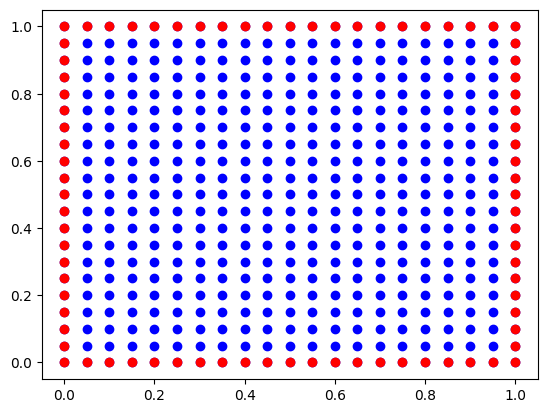

In [41]:
plt.scatter(entradas_treinamento_fisico[:,0],entradas_treinamento_fisico[:,1], color = "blue")
plt.scatter(entradas_treinamento[:,0],entradas_treinamento[:,1],color = "red")
plt.show()

In [42]:
modelo = Sequential([Input((2,)),
                    Dense(64,activation="tanh"),
                    Dense(64,activation="tanh"),
                    Dense(1,activation="linear")])
modelo.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,417 (17.25 KB)

 Trainable params: 4,417 (17.25 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
taxa_de_treinamento = 0.0005
k_fisica = 1e-2

otimizador = Adam(learning_rate=taxa_de_treinamento)

@tf.function # Isso acelera a função
def loop_treinamento_PINN(entradas,saidas,x_fis,k_fisica): #entradas e saídas são as que damos para o modelo e x_fis é o tensor de entradas de treinamento físico
    with tf.GradientTape() as tape: # Fita responsável por pegar os gradientes da perda em relação ao modelo
        perda_normal = tf.reduce_mean(tf.square(modelo(entradas)-saidas)) # MSE padrão das saídas do modelo com as saídas dadas
        with tf.GradientTape() as t1:
            t1.watch(x_fis)
            with tf.GradientTape() as t2:
                t2.watch(x_fis)
                w = modelo(x_fis) # Posição do oscilador
            primeiras_derivadas = t2.batch_jacobian(w,x_fis)[:,0,:] # Retorna um tensor de shape (n_batches,2), onde a primeira feature é dw/dx e a segunda é dw/dy
        segundas_derivadas = t1.batch_jacobian(primeiras_derivadas,x_fis) # Retorna um tensor de shape (n_batches,2,2), que representa todas as segundas derivadas parciais
        d2wd2x = segundas_derivadas[:,0,0]  # ∂²w/∂x²
        d2wd2y = segundas_derivadas[:,1,1]  # ∂²w/∂y²
        EDP_sistema = d2wd2x + d2wd2y + 1.0
        perda_fisica = k_fisica*tf.reduce_mean(tf.square(EDP_sistema))
        perda_total = perda_normal + perda_fisica
    gradientes_modelo = tape.gradient(perda_total,modelo.trainable_variables)
    otimizador.apply_gradients(zip(gradientes_modelo,modelo.trainable_variables)) # Dá os gradientes para o otimizador ADAM minimizar a perda
    return perda_fisica, perda_normal, perda_total


In [44]:
epochs = 25000

for epoch in range(epochs+1):
    fisica,normal,total = loop_treinamento_PINN(entradas_treinamento,saidas_treinamento,entradas_treinamento_fisico,k_fisica)
    if (epoch)%5000 == 0:
        tf.print(epoch,fisica,normal,total)

0 0.012313555 0.0975461751 0.109859727
5000 6.37252961e-05 0.000264175789 0.0003279011
10000 4.60860356e-05 0.000141251527 0.000187337559
15000 2.00521172e-05 1.42954323e-05 3.43475476e-05
20000 1.02766089e-05 6.04674415e-06 1.63233526e-05
25000 4.75690149e-06 2.91390779e-06 7.67080928e-06


Vamos fazer outra malha mais detalhada, com intervalos menores para ver como ficou a previsão final:

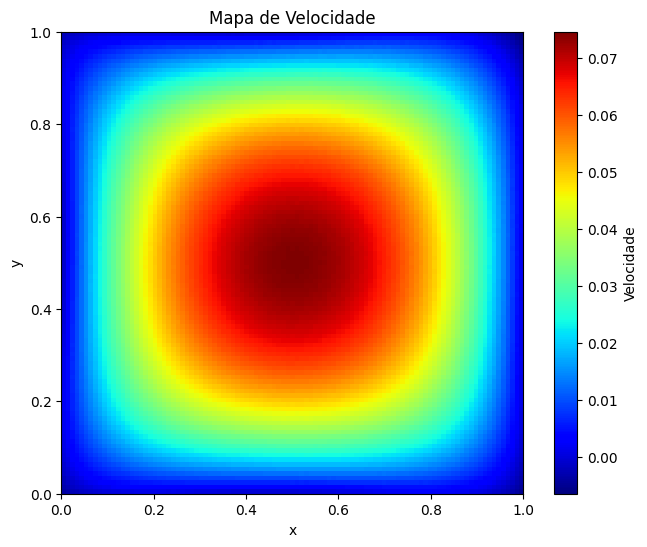

In [45]:
def plotar_velocidade(modelo):
    dx_plot = 0.01

    xs_plot = np.arange(x_inicial, x_final+dx_plot, dx_plot ,dtype="float32")
    ys_plot = np.arange(y_inicial, y_final+dx_plot, dx_plot ,dtype="float32")
    sigma_plot = []

    for x in xs_plot:
        for y in ys_plot:
            sigma_plot.append([x, y])

    sigma_plot = tf.convert_to_tensor(sigma_plot)
    prev = np.array(modelo(sigma_plot)).reshape(-1)
    cont1=0
    cont2=0
    valores_velocidade = np.zeros((len(xs_plot),len(ys_plot)))

    for i in range(len(sigma_plot)):
        valores_velocidade[cont1,cont2] = prev[i]
        cont2+=1
        if cont2==len(ys_plot):
            cont1+=1
            cont2=0
    
    valores_velocidade = valores_velocidade.T


    plt.figure(figsize=(8, 6))
    plt.imshow(
        valores_velocidade, 
        extent=(x_inicial, x_final, y_inicial, y_final), 
        origin='lower', 
        cmap='jet', 
        interpolation='nearest'  
    )
    plt.colorbar(label='Velocidade')
    plt.title('Mapa de Velocidade')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

plotar_velocidade(modelo)

Note que o nosso mínimo da velocidade não está em 0 como deveria ser, isso pode ser amenizado com um loop de treinamento modificado, onde vamos gradualmente abaixando k_fisica conforme o modelo vai aprendendo a solução para ir enfatizando a condição de contorno de 0 na fronteira. Como uma solução temporária, vamos somente rodar novamente o treinamento com k_fisica menor.

0 9.48574908e-08 3.06062361e-06 3.15548118e-06
5000 3.48118704e-07 9.96546e-07 1.34466472e-06
10000 3.4942795e-07 1.08498591e-06 1.43441389e-06
15000 3.38072169e-07 1.03656691e-06 1.37463906e-06
20000 3.35806334e-07 1.35198377e-06 1.68779013e-06
25000 3.30468254e-07 8.68543452e-07 1.19901165e-06
30000 3.32408717e-07 8.36085917e-07 1.16849469e-06
35000 3.33700569e-07 1.02849083e-06 1.36219137e-06
40000 3.40026e-07 7.94648258e-07 1.13467422e-06
45000 3.43650328e-07 8.48462889e-07 1.19211325e-06
50000 3.46053099e-07 7.33163859e-07 1.07921699e-06


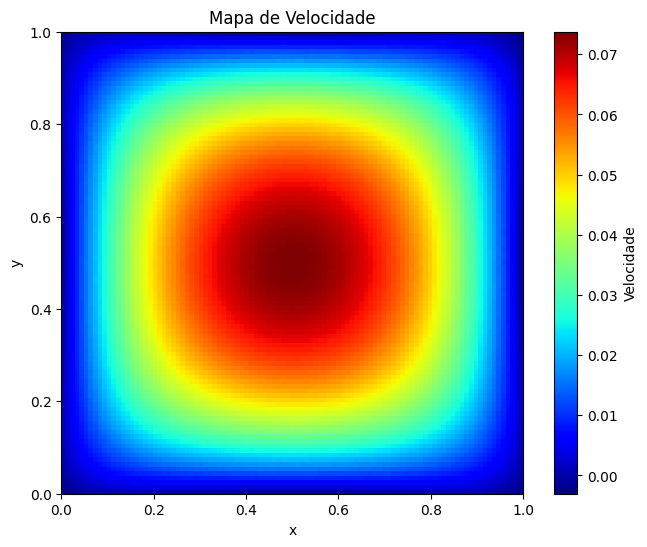

In [46]:
epochs = 50000
k_fisica = 2e-4

for epoch in range(epochs+1):
    fisica,normal,total = loop_treinamento_PINN(entradas_treinamento,saidas_treinamento,entradas_treinamento_fisico,k_fisica)
    if (epoch)%5000 == 0:
        tf.print(epoch,fisica,normal,total)

plotar_velocidade(modelo)

Melhorou um pouco, infelizmente essa tarefa é um pouco difícil de realizar e muitas vezes requer muita investigação e epochs, porém de qualquer forma, a forma da solução é basicamente essa. Note que obtemos uma solução contínua da velocidade dentro do retângulo, pois, apesar de termos treinado com a malha com espaçamento maior, podemos utilizar o modelo para prever em uma malha mais fina sem muito erro.

Uma forma interessante de aplicar as condições de contorno é fazer com que a saída seja multiplicada por uma função B(x,y), que é 0 nas paredes:

\begin{equation*}
    saida := B(x,y)saida 
\end{equation*}

No caso do quadrado, temos que B(x,y) = xy(1-x)(1-x)

In [50]:
from tensorflow.keras.layers import Layer

class Modelo_Lagaris(Layer):
    def __init__(self, boundary_func, **kwargs):
        super().__init__(**kwargs)
        self.boundary_func = boundary_func  # B(x,y)
    def call(self, inputs, nn_output):
        x = inputs[:, 0:1]
        y = inputs[:, 1:2]
        phi = x*(1.0-x)*y*(1.0-y)
        return self.boundary_func(inputs) + phi * nn_output

inputs = Input(shape=(2,))
hidden = Dense(64, activation="tanh")(inputs)
for _ in range(1):
    hidden = Dense(64, activation="tanh")(hidden)
nn_out = Dense(1,dtype=tf.float64)(hidden)

def zero_boundary(xy):
    return tf.zeros_like(xy[:, :1])

u_hat = Modelo_Lagaris(boundary_func=zero_boundary)(inputs, nn_out)

modelo = tf.keras.Model(inputs=inputs, outputs=u_hat)
modelo.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 64)        │        192 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_52 (Dense)    │ (None, 64)        │      4,160 │ dense_51[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_18 (Cast)      │ (None, 64)        │          0 │ dense_52[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_53 (Dense)    │ (None, 1)         │         65 │ cast_18[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_19 (Cast)      │ (None, 1)         │          0 │ dense_53[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ modelo__lagaris_9   │ (None, 1)         │          0 │ input_layer_13[0… │
│ (Modelo_Lagaris)    │                   │            │ cast_19[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,417 (17.51 KB)

 Trainable params: 4,417 (17.51 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
taxa_de_aprendizado = 0.0005
optimizer = tf.optimizers.Adam(learning_rate=taxa_de_aprendizado)
@tf.function
def loop_treinamento(x_phys_func):
    with tf.GradientTape() as tape:
        
        # Perda física EDP
        with tf.GradientTape() as t2:
            t2.watch(x_phys_func)
            with tf.GradientTape() as t1:
                t1.watch(x_phys_func)
                u_m = modelo(x_phys_func) 
            dx = t1.batch_jacobian(u_m, x_phys_func)[:,0,:]

        dx2 = t2.batch_jacobian(dx, x_phys_func)
        ddx2 = dx2[:, 0, 0]  # ∂²u/∂x²
        ddy2 = dx2[:, 1, 1]  # ∂²u/∂y²

        #Note que agora só temos a perda fisica pois a CC está sendo aplicada pela ultima camada que multiplica B(x,y)
        Phys_loss = tf.reduce_mean(tf.square(ddx2 + ddy2 + 1.0))

    # Backpropagation
    gradients = tape.gradient(Phys_loss, modelo.trainable_variables)
    optimizer.apply_gradients(zip(gradients, modelo.trainable_variables))
    del tape
    del t1
    del t2
    
    return Phys_loss

0 1.39350283
5000 0.0262115374
10000 0.0102113457
15000 0.00936499238
20000 0.0091737425
25000 0.00912806857
30000 0.00911248475
35000 0.00910008606
40000 0.00909379683


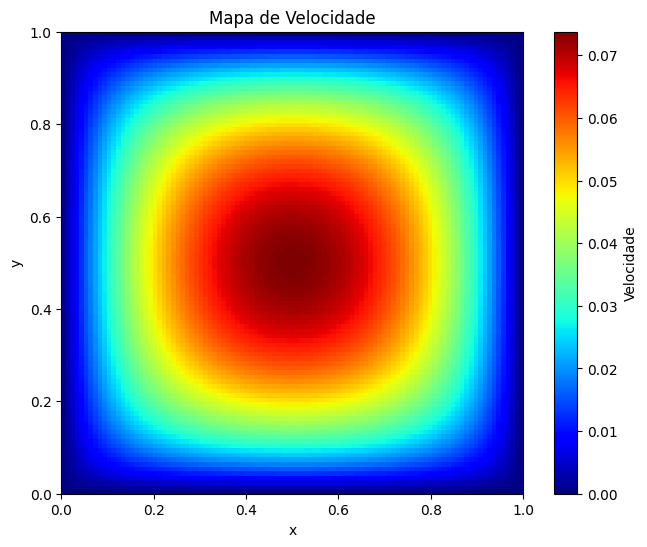

In [52]:
epochs = 40000

for epoch in range(epochs+1):
    fisica = loop_treinamento(entradas_treinamento_fisico)
    if (epoch)%5000 == 0:
        tf.print(epoch,fisica)

plotar_velocidade(modelo)

Vamos resolver agora a equação do calor unidimensional:

\begin{equation*}
    \frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2}
\end{equation*}

Vamos abordar esse problema para o intervalo x = [0,1.0], com as condições de contorno:


\begin{array}{ll}
u(0,t) = 3.0, & \text{para } t > 0 \\
u(1.0,t) = 3.0 & \text{para } t > 0 \\
u(x,0) = 3.0sen(2πx)+3.0, & \text{para } 0 < x < L
\end{array}



In [237]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [246]:
dx = 0.05
dt = 0.05
x_inicial = 0
x_final = 1.0
t_inicial = 0
t_final = 1.0

xs = np.arange(x_inicial, x_final+dx, dx ,dtype="float32")
ts = np.arange(t_inicial, t_final+dt, dt ,dtype="float32")
sigma = []
u_t0 = []
u_contorno = []

for x in xs:
    for t in ts:
        if t==0 and (x!=x_inicial and x!=x_final):
            u_t0.append([x,t]) # Condiçao inicial para a barra inteira menos nas pontas
        if t!=0.0 and (x==0.0 or x==1.0):
            u_contorno.append([x,t])
        sigma.append([x, t]) # Malha inteira 
    


entradas_treinamento_fisico = tf.convert_to_tensor(sigma,dtype=tf.float32)
entradas_treinamento =tf.cast(tf.concat((u_t0,u_contorno),0),dtype=tf.float32)
saidas1 = 3*tf.sin(2*np.pi*np.array(u_t0)[:,0])+3 # Primeira condição de contorno u(0,x)= 3*sin(2*π*x)
saidas2 = tf.ones(len(u_contorno)//2)*3.0 # Segunda condição de contorno u(0,t) = 3
saidas3 = tf.ones(len(u_contorno)//2)*3.0 # Terceira condição de contorno u(1,t) 3
saidas_treinamento = tf.expand_dims(tf.concat((saidas1,saidas2,saidas3),0),1)

Text(0, 0.5, 'Temperatura')

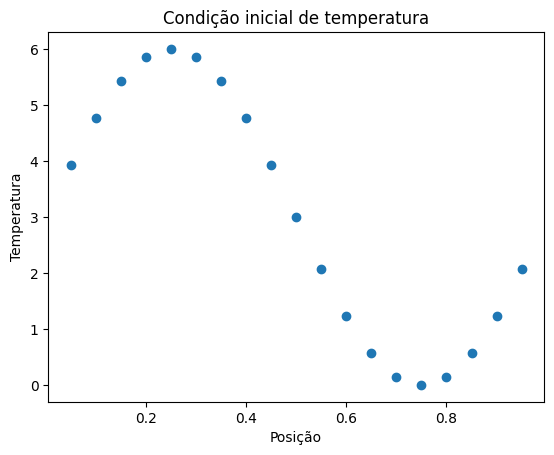

In [250]:
plt.title("Condição inicial de temperatura")
plt.scatter(xs[1:-1],np.array(saidas1))
plt.xlabel("Posição")
plt.ylabel("Temperatura")

In [251]:
modelo = Sequential([Input((2,)),
                    Dense(64,activation="tanh"),
                    Dense(64,activation="tanh"),
                    Dense(1,activation="linear")])

In [252]:
taxa_de_treinamento = 0.0001
k_fisica = 1e-2

otimizador = Adam(learning_rate=taxa_de_treinamento)

@tf.function # Isso acelera a função
def loop_treinamento_PINN(entradas,saidas,x_fis,k_fisica): #entradas e saídas são as que damos para o modelo e x_fis é o tensor de entradas de treinamento físico
    with tf.GradientTape() as tape: # Fita responsável por pegar os gradientes da perda em relação ao modelo
        perda_normal = tf.reduce_mean(tf.square(modelo(entradas)-saidas)) # MSE padrão das saídas do modelo com as saídas dadas
        with tf.GradientTape() as t1:
            t1.watch(x_fis)
            with tf.GradientTape() as t2:
                t2.watch(x_fis)
                w = modelo(x_fis) # Posição do oscilador
            primeiras_derivadas = t2.batch_jacobian(w,x_fis)[:,0,:] # Retorna um tensor de shape (n_batches,2), onde a primeira feature é du/dx e a segunda é du/t
        segundas_derivadas = t1.batch_jacobian(primeiras_derivadas,x_fis) # Retorna um tensor de shape (n_batches,2,2), que representa todas as segundas derivadas parciais
        d2ud2x = segundas_derivadas[:,0,0]  # ∂²u/∂x²
        dudt = primeiras_derivadas[:,1]  # ∂u/∂t²
        EDP_sistema = dudt - 0.1*d2ud2x
        perda_fisica = k_fisica*tf.reduce_mean(tf.square(EDP_sistema))
        perda_total = perda_normal + perda_fisica
    gradientes_modelo = tape.gradient(perda_total,modelo.trainable_variables)
    otimizador.apply_gradients(zip(gradientes_modelo,modelo.trainable_variables)) # Dá os gradientes para o otimizador ADAM minimizar a perda
    return perda_fisica, perda_normal, perda_total

In [253]:
epochs = 25000

for epoch in range(epochs+1):
    fisica,normal,total = loop_treinamento_PINN(entradas_treinamento,saidas_treinamento,entradas_treinamento_fisico,k_fisica)
    if (epoch)%5000 == 0:
        tf.print(epoch,fisica,normal,total)

0 0.000547809293 10.4143944 10.4149418
5000 0.0461321548 0.652041495 0.698173642
10000 0.00255066296 0.00116909482 0.00371975778
15000 0.000101311816 1.35202345e-05 0.000114832052
20000 3.62626779e-05 3.89323e-06 4.01559082e-05
25000 2.47358112e-05 2.36409278e-06 2.70999044e-05


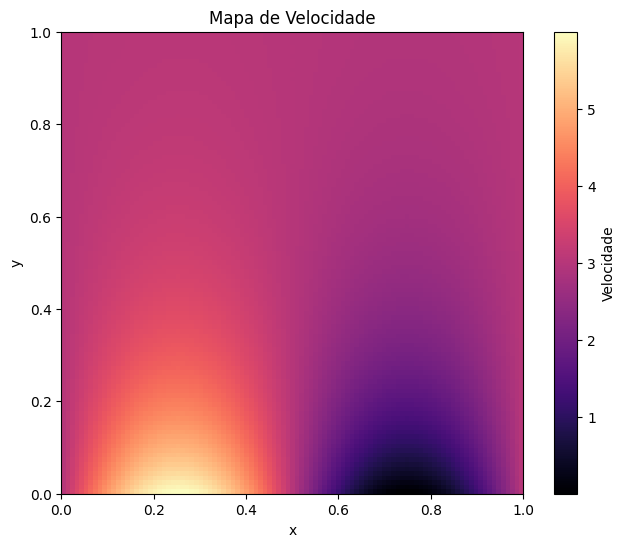

In [255]:
def plotar_velocidade():
    dx_plot = 0.01

    xs_plot = np.arange(x_inicial, x_final+dx_plot, dx_plot ,dtype="float32")
    ys_plot = np.arange(t_inicial, t_final+dx_plot, dx_plot ,dtype="float32")
    sigma_plot = []

    for x in xs_plot:
        for y in ys_plot:
            sigma_plot.append([x, y])

    sigma_plot = tf.convert_to_tensor(sigma_plot)
    prev = np.array(modelo(sigma_plot)).reshape(-1)
    cont1=0
    cont2=0
    valores_velocidade = np.zeros((len(xs_plot),len(ys_plot)))

    for i in range(len(sigma_plot)):
        valores_velocidade[cont1,cont2] = prev[i]
        cont2+=1
        if cont2==len(ys_plot):
            cont1+=1
            cont2=0

    valores_velocidade = valores_velocidade.T


    plt.figure(figsize=(8, 6))
    plt.imshow(
        valores_velocidade, 
        extent=(x_inicial, x_final, t_inicial, t_final), 
        origin="lower", 
        cmap='magma', 
        interpolation='nearest'  
    )
    plt.colorbar(label='Velocidade')
    plt.title('Mapa de Velocidade')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

plotar_velocidade()

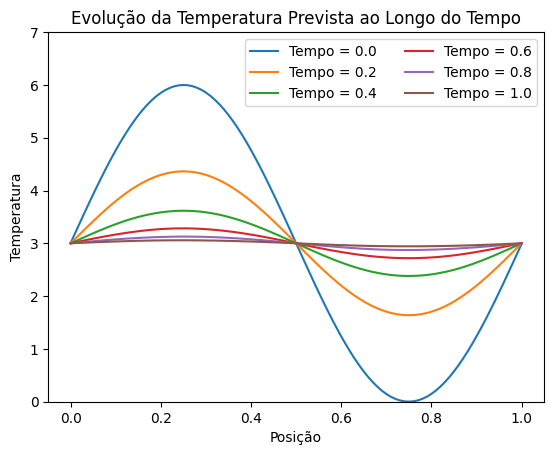

In [271]:
ts = np.arange(0,1.1,0.2)
dx_plot = 0.01
xs_plot = np.arange(0,1.0+dx_plot,dx_plot)
for t in ts:
    teste = []
    for x in xs_plot:
        teste.append((x,t))
    teste = np.array(teste).reshape(-1,2)
    prev = modelo(teste)
    plt.ylim(0,7)
    plt.plot(xs_plot,prev, label = f"Tempo = {t:.1f}")
    plt.legend(ncols=2)

plt.title("Evolução da Temperatura Prevista ao Longo do Tempo")
plt.xlabel("Posição")
plt.ylabel("Temperatura")
plt.show()


Vamos por último, resolver a equação de Schrodinger unidimensional, para isso, vamos separá-la em duas equações acopladas de valores reais. A partir da equação de Schrodinger:


\begin{equation*}
    i\hbar\frac{\partial\psi}{\partial t} = -\frac{\hbar^2}{2m}\frac{\partial^2\psi}{\partial x^2} + V(x)\psi
\end{equation*}

Temos que em geral:

\begin{equation*}
\psi(x,t) = u(x,t) + iv(x,t)
\end{equation*}

Então, a parte esquerda fica:

\begin{equation*}

i\hbar\frac{\partial\psi}{\partial t} = i\hbar(\dot{u} + i\dot{v}) = \hbar(i\dot{u}-\dot{v})
\end{equation*}

Por outro lado temos que $\hat{H}(u+iv) = \hat{H}u + i\hat{H}v$, e como o operador hamiltoniano geralmente mapeia funções reais a outras funções reais, temos que:

\begin{equation*}
-\hbar\dot{v} = \hat{H}u
\end{equation*}

\begin{equation*}
\hbar\dot{u} = \hat{H}v
\end{equation*}

Logo conseguimos duas EDPs acopladas que descrevem a equação de Schrodinger em termos de somente valores reais. Com isso, conseguimos montar nossa PINN, vamos resolver o caso com a condição inicial abaixo e uma simples barreira de potencial:

\begin{array}{llll}
\psi(x,0) = 2sin(2\pi(x-0.5)) & \text{para } 0.5 \lt x \lt 1.0\\

\psi(x,0) = 0.0 & \text{para } x \lt 0.5, x \gt 1.0\\

\psi(-1.0,t) = \psi(1.0,t) = 0.0\\

V(x,t) = 1.5\pi &\text{para } |x| \lt 0.1\\
V(x,t) = 0.0 &\text{para } |x| \gt 0.1

\end{array}


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

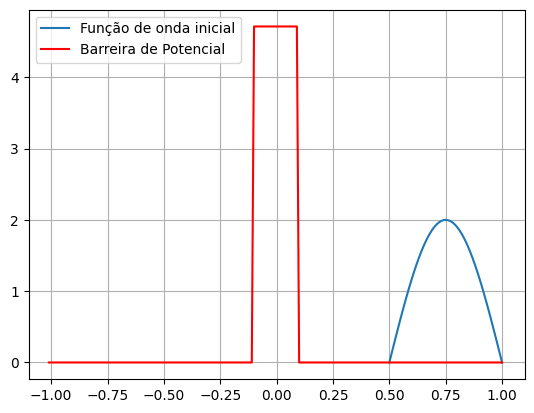

In [7]:
dx = 0.01
xs = np.arange(-1.0-dx, 1.0+dx,dx)
u = np.zeros(len(xs))
x_potencial = np.zeros(20)
V0 = 1.5*np.pi
potencial = np.linspace(0,V0,20)
potencial = np.where(np.abs(xs)<0.1, V0, 0.)
inicio = np.where(np.abs(xs-0.5)<0.0001)[0][0]
fim = np.where(np.abs(xs-1.0)<0.0001)[0][0]+1
u[inicio:fim] = 2*np.sin(2*np.pi*(xs[inicio:fim]-0.5))
v = np.zeros(len(xs))

plt.plot(xs[inicio:fim],u[inicio:fim],label="Função de onda inicial")
plt.xlim(-1.1,1.1)
plt.plot(xs,potencial,"r-",label="Barreira de Potencial ")
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [13]:
t_final = 0.1
dt = 0.005
ts = np.arange(dt,t_final+dt,dt)

condicoes_contorno = []
for t in ts:
    condicoes_contorno.append((-1.0, t))
    condicoes_contorno.append((1.0, t))
    
entradas_treinamento_inicial = tf.cast(np.stack((xs,np.zeros(len(xs))),1),dtype=tf.float32) 
saidas_treinamento_inicial = tf.cast(np.stack((u,v),1),dtype=tf.float32)

entradas_treinamento_contorno = tf.cast(condicoes_contorno, dtype=tf.float32)
saidas_treinamento_contorno = tf.zeros((len(entradas_treinamento_contorno),2))

entradas_treinamento = tf.concat((entradas_treinamento_inicial,entradas_treinamento_contorno),0) 
saidas_treinamento = tf.concat((saidas_treinamento_inicial,saidas_treinamento_contorno),0) 

entradas_treinamento_fisico = []
cont=0
cont_inicial = len(xs)*len(ts)+1
cont_final=0
for x in xs:
    for t in ts:
        if np.sqrt(x*x) < 1e-7:
            if cont_inicial>cont:
                cont_inicial = cont
            cont_final = cont
        entradas_treinamento_fisico.append((x,t))
        cont+=1

entradas_treinamento_fisico = tf.cast(np.array(entradas_treinamento_fisico),dtype=tf.float32)
potencial_fisico = tf.where(tf.abs(entradas_treinamento_fisico[:,0])<0.1, V0, 0.)



In [14]:
modelo = Sequential([Input((2,)),
                    Dense(64,activation="tanh"),
                    Dense(64,activation="tanh"),
                    Dense(64,activation="tanh"),
                    Dense(64,activation="tanh"),
                    Dense(2,activation="linear")])

In [15]:
taxa_de_treinamento = 0.0005
k_fisica = 1e-3

otimizador = Adam(learning_rate=taxa_de_treinamento)

@tf.function # Isso acelera a função
def loop_treinamento_PINN(entradas,saidas,x_fis,potencial_fisico,k_fisica): #entradas e saídas são as que damos para o modelo e x_fis é o tensor de entradas de treinamento físico
    with tf.GradientTape() as tape: # Fita responsável por pegar os gradientes da perda em relação ao modelo
        perda_normal = tf.reduce_mean(tf.square(modelo(entradas)-saidas)) # MSE padrão das saídas do modelo com as saídas dadas
        with tf.GradientTape() as t1:
            t1.watch(x_fis)
            with tf.GradientTape() as t2:
                t2.watch(x_fis)
                psi = modelo(x_fis) # Posição do oscilador
            primeiras_derivadas = t2.batch_jacobian(psi,x_fis) # (n_batches) (u,v) (∂x,∂t)
        segundas_derivadas = t1.batch_jacobian(primeiras_derivadas,x_fis) # (n_batches) (u,v) (∂x,∂t) (∂x,∂t)
        u = psi[:,0]
        v = psi[:,1]
        dudt = primeiras_derivadas[:,0,1]
        dvdt = primeiras_derivadas[:,1,1]
        d2ud2x = segundas_derivadas[:,0,0,0] 
        d2vd2x = segundas_derivadas[:,1,0,0]
        EDP_sistema1 = dudt + 0.5*d2vd2x - potencial_fisico*v 
        EDP_sistema2 = dvdt - 0.5*d2ud2x + potencial_fisico*u
        perda_fisica_u = k_fisica*tf.reduce_mean(tf.square(EDP_sistema1))
        perda_fisica_v = k_fisica*tf.reduce_mean(tf.square(EDP_sistema2))
        perda_fisica = perda_fisica_u + perda_fisica_v 
        perda_total = perda_normal + perda_fisica

    gradientes_modelo = tape.gradient(perda_total,modelo.trainable_variables)
    otimizador.apply_gradients(zip(gradientes_modelo,modelo.trainable_variables)) # Dá os gradientes para o otimizador ADAM minimizar a perda
    return perda_fisica, perda_normal, perda_total

In [16]:
epochs = 50000

for epoch in range(epochs+1):
    fisica,normal,total = loop_treinamento_PINN(entradas_treinamento,saidas_treinamento,entradas_treinamento_fisico,potencial_fisico,k_fisica)
    if (epoch)%5000 == 0:
        tf.print(epoch,fisica,normal,total)

0 3.1192445e-05 0.226177886 0.226209074
5000 0.000361043203 0.000222844115 0.000583887333
10000 0.000176345202 8.32366422e-05 0.000259581837
15000 6.63312821e-05 4.58155228e-05 0.000112146809
20000 3.29601644e-05 1.71788979e-05 5.01390605e-05
25000 2.68446493e-05 1.98146608e-05 4.66593119e-05
30000 2.01471339e-05 1.21268558e-05 3.22739907e-05
35000 1.81557643e-05 1.35915625e-05 3.17473277e-05
40000 2.14459324e-05 1.2958978e-05 3.44049113e-05
45000 2.15539767e-05 1.50936385e-05 3.66476161e-05
50000 1.36739636e-05 1.55876314e-05 2.9261595e-05


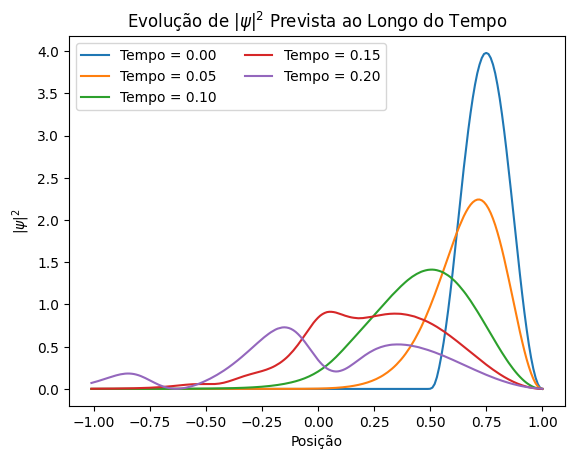

In [17]:
t_plot = np.arange(0,0.25,0.05)

for t in t_plot:
    teste = []
    for x in xs:
        teste.append((x,t))
    teste = np.array(teste)
    prev = modelo(teste)
    prev_real = (prev[:,0]**2 + prev[:,1]**2)
    plt.plot(xs,prev_real, label = f"Tempo = {t:.2f}")
    plt.legend(ncols=2)

plt.title(f"Evolução de {r'$|\psi|^2$'} Prevista ao Longo do Tempo")
plt.xlabel("Posição")
plt.ylabel(r'$|\psi|^2$')
plt.show()